## Initialisation 

In [75]:
#Declaring imports
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [76]:
#Files
train_data_path = 'train.csv'
test_data_path = 'test.csv'


In [77]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
all_data = [train_df, test_df]

In [87]:
#Renaming columns so its easier to understand
for dataset in all_data:
    dataset.rename(inplace=True, columns={'PassengerId':'Id', 'Pclass':'TicketClass', 'SibSp':'NumSiblingsSpouse', 'Parch':'NumParentsChild', 'ticket':'TicketNumber', 'fare':'Fare', 'cabin':'CabinNumber', 'embarked':'PortEmbarked'})

# Exploratory Data Analysis
Seeing the rough distribution of the different columns

In [79]:
#Seeing how the dataframe is like
train_df.describe()

,Id,Survived,TicketClass,Age,NumSiblingsSpouse,NumParentsChild,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


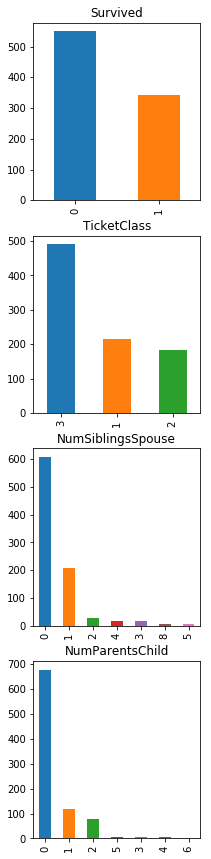

In [80]:
#Seeing the distribution of discrete data
col_list =  ['Survived', 'TicketClass', 'NumSiblingsSpouse', 'NumParentsChild']
fig, axes = plt.subplots(nrows=len(col_list), ncols=1, figsize=(3,15))
for i, col_name in enumerate(col_list):
    train_df[col_name].value_counts().plot(kind='bar', ax=axes[i], title = col_name)


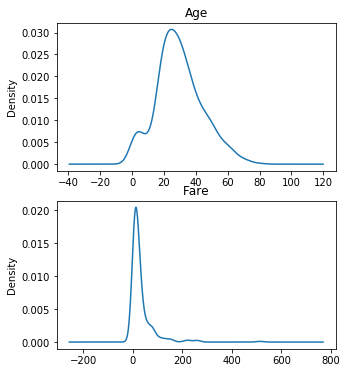

In [81]:
#Plotting continuous distributions
col_list = ['Age', 'Fare']
fig, axes = plt.subplots(nrows=len(col_list), ncols=1, figsize=(5,6))
for i, col_name in enumerate(col_list):
    train_df[col_name].plot(kind='density', ax=axes[i], title = col_name)


In [82]:
#Finding the number of null values in each column to see which column has a problem
vals = {}
for key in train_df.keys():
    vals[key] = [train_df[key].isnull().sum()]
pd.DataFrame.from_dict(vals)

,Age,Cabin,Embarked,Fare,Id,Name,NumParentsChild,NumSiblingsSpouse,Sex,Survived,Ticket,TicketClass
0,177,687,2,0,0,0,0,0,0,0,0,0


## Seeing how the different features affect outcome

In [83]:
print(train_df[['TicketClass','Survived']].groupby(['TicketClass']).mean())

             Survived
TicketClass          
1            0.629630
2            0.472826
3            0.242363


In [84]:
print(train_df[["Sex", "Survived"]].groupby(['Sex']).mean())

        Survived
Sex             
female  0.742038
male    0.188908


In [85]:
print(train_df[["Sex","Survived"]].groupby(["Sex"]).mean())

        Survived
Sex             
female  0.742038
male    0.188908


In [102]:
for dataset in all_data:
    dataset["FamilySize"] = dataset["NumSiblingsSpouse"] + dataset["NumParentsChild"] + 1
print (train_df[['FamilySize', 'Survived']].groupby(['FamilySize']).mean())

            Survived
FamilySize          
1           0.303538
2           0.552795
3           0.578431
4           0.724138
5           0.200000
6           0.136364
7           0.333333
8           0.000000
11          0.000000


In [103]:
for dataset in all_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train_df[['IsAlone', 'Survived']].groupby(['IsAlone']).mean())

         Survived
IsAlone          
0        0.505650
1        0.303538


## Handling NA values

In [111]:
#Drop if more than a number of NA values
for dataset in all_data:
    length = len(dataset.keys())
    dataset.dropna(thresh=length-5, inplace=True)

In [112]:
#I just decided to drop all
for dataset in all_data:
    dataset.dropna(inplace=True)

In [114]:
for dataset in all_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;